# A simple example of the analysis in Dessert et al. _Science_ 2020

This notebook contains a pedagogical treatment of an example analysis of the stacked data from the MOS camera onboard XMM-Newton in [Dessert et al. _Science_ 2020](https://science.sciencemag.org/content/367/6485/1465). These example analyses can be performed using the data products produced in that reference. In order to make the notebook relatively short and self-contained, we make two simplification on the dataset we treat.

Firstly, we restrict ourselves to data collected by the MOS data. The reason is that the MOS camera has a simpler instrument response (in particular the PN camera has a variable energy binning). Nevertheless, keep in mind that the data here is only half the story: the PN data produces comparable limits as the MOS data (see the paper).

Secondly, we work with the stacked dataset produced by combining the various MOS exposures. For the main result in Dessert et al. _Science_ 2020, we instead use a joint likelihood approach. The joint likelihood has a variety of advantages relative to stacking the data, as described in the paper. Still, comparable sensitivity is achieved by stacking the data, and as it's the simpler of the two approaches we pursue it here.  However, we _strongly_ recommend the joint likelihood approach for scientific applications.  It is more sensitive than the stacked data approach and also less subject to systematic uncertainties.

Finally, if you use the data in this example in a publication, please cite Dessert et al. _Science_ 2020.

**Please direct any questions to bsafdi@umich.edu.**

In [1]:
# Import required modules

%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import sys,os
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2 as chi2_scipy
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from scipy.optimize import dual_annealing

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True

**NB**: In this notebook, we minimize with `scipy` so that it is easy to run for the interested reader. For scientific analysis, we recommend [Minuit](https://iminuit.readthedocs.io/en/latest/) or [Multinest](https://github.com/JohannesBuchner/MultiNest) as these minimizers are typically more stable. In our paper, we used Minuit.

# Define signal line energy

By default we will look for an anomalous line at 3.55 keV, as defined by the EUXL parameter below, denoting the energy of the unidentified X-ray line. Lines at different energies can be searched for by changing this parameter accordingly (for example to 3.5 keV). We start with 3.55 keV as this is within the best energy range suggested by [Bulbul et al. _Astrophys. J._ 2014](https://iopscience.iop.org/article/10.1088/0004-637X/789/1/13).

In [2]:
EUXL = 3.50#3.48#3.50 [keV]

**NB:** changing EUXL will of course vary the results below, and values in the surrounding discussion will not necessarily be reflective.

# Load in the data and models

First we will load in the data products that we will use in the analysis.  These include the stacked MOS data, associated energy bins, and uncertainties. 

We will use data from two regions of interest (ROI):
- **Signal Region (SR)**: 5-45 degrees from the Galactic Center, this was the fiducial ROI in our main analysis;
- **Background Region (BR)**: 60-90 degrees from the Galactic Center, a useful region for studying background as it contains less dark matter.

We also load the appropriately averaged D-factors for these two regions (ROIs) for our fiducial NFW profile, along with the respective exposure times.

In [3]:
## Signal Region (5-45 degrees)
data = np.load("../data/data_mos_boyarsky_ROI_our_cuts.npy") # cts/s/keV
data_yerrs = np.load("../data/data_yerrs_mos_boyarsky_ROI_our_cuts.npy") #cts/s/keV
QPB = np.load("../data/QPB_mos_boyarsky_ROI_our_cuts.npy") #cts/s/keV


Exp = 8.488925e6# for our signal region
D_signal = 4.46e28 # for our signal region [keV/cm^2]


## Background Region (80-180 degrees)
# Data and associated errors
data_bkg = np.load("../data/data_mos_bkg_ROI.npy") #[cts/s/keV]
data_yerrs_bkg = np.load("../data/data_yerrs_mos_bkg_ROI.npy") #[cts/s/keV]

# Exposure time
Exp_bkg = 61.10673578304739e6# [s]

# D-factor averaged over the background ROI
D_bkg = 1.17e28 # [keV/cm^2]

## Energy binning appropriate for both the signal and background
Energies=np.load("../data/mos_energies.npy") #keV

## Load in the Models

Next we use the models that will be used in fitting the above data.

There are a sequence of models corresponding to physical line fluxes at the energies specified by `Es_line`.  That is, `mod_UXL` gives the detectors counts as a function of energy after forward modeling a physical line at EUXL keV with a flux of 1 cts/cm$^2$/s/sr.

In [4]:
mods = np.load("../data/mos_mods.npy") #These are the forward-modeled lines at energies given below
Es_line = np.load("../data/mos_mods_line_energies.npy") #The energies for the forward modeled lines

det_res = np.load("../data/mos_det_res.npy") #This is an approximate forward-modeling matrix for MOS

In [5]:
arg_UXL = np.argmin((Es_line-EUXL)**2)
mod_UXL = mods[arg_UXL]

print "The energy of our "+str(EUXL)+" keV line example will be: "+str(Es_line[arg_UXL])+" keV"

The energy of our 3.5 keV line example will be: 3.5025041736227047 keV


In [6]:
# A folded powerlaw function
def folded_PL(A,n):
    mod_F = np.matmul(det_res,A*Energies**n) 
    return mod_F
    

In [7]:
# How to go from flux to sin^2(2\theta)
def return_sin_theta_lim(E_line,flux,D_factor):
    """
    D_factor [keV/cm^2]
    flux [cts/cm^2/s/sr]
    E_line [keV] (dark matter mass is twice this value)
    returns: associated sin^2(2theta)
    """
    DMmass = 2.*E_line
    res = (4.*np.pi*DMmass/D_factor)/1.361e-22*(1/DMmass)**5*flux
    return res

# Visualize the data

## Plot of the data

Data in the signal region, where the dashed vertical line denotes the location of a putative signal line.

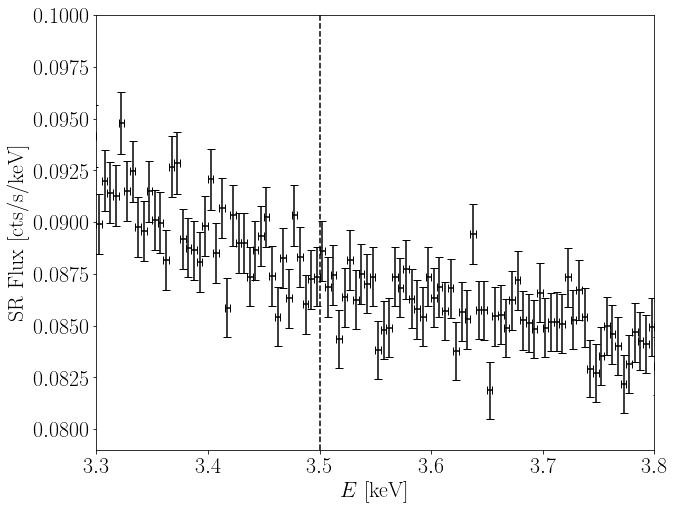

In [10]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(7.9e-2,0.1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.show()

# Statistical analysis

Now, let's perform a rigorous statistical analysis, using profile likelihood. As we operate in the large counts limit for the stacked data, we can perform a simple $\chi^2$ analysis rather than a full joint likelihood analysis as used by default in Dessert et al. 2020.

**NB:** we will model the background over this narrow region as a simple featureless polynomial. In particular, we choose a quadratic function as used for the stacked analysis in Dessert et al. 2020. Nevertheless, similar results are obtained for a simple power law or most other smooth functions. Users are encouraged to try alternative models.

In [11]:
## Define the functions we will use

class chi2:
    """ A set offunctions for calculation the chisq associated with different hypotheses
    """
    def __init__(self,ens,dat,err,null_mod,sig_template):
        self._ens = ens
        self._dat = dat
        self._err = err
        self._null_mod = null_mod
        self._sig_template = sig_template
        self._A_sig = 0.0
    
    def chi2(self,x):
        null_mod = self._null_mod(self._ens,x[1:])
        sig_mod = self._sig_template*x[0]
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2)
    
    def chi2_null(self,x):
        null_mod = self._null_mod(self._ens,x)
        return np.sum((self._dat - null_mod)**2/self._err**2)
    
    def chi2_fixed_signal(self,x):
        null_mod = self._null_mod(self._ens,x)
        sig_mod = self._sig_template*self._A_sig
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2) 
    
    def fix_signal_strength(self,A_sig):
        self._A_sig = A_sig

## Fit within $E_{\rm UXL} \pm 0.25$ keV

First, we will fit the models from $[E_{\rm UXL}-0.25,\,E_{\rm UXL}+0.25]$ keV. Later in this notebook, we broaden this range to 3.0 to 4.0 keV. For the default $E_{\rm UXL} = 3.55$ keV, this correspond to $3.3~{\rm keV} < E < 3.8~{\rm keV}$.

To begin with then, let's reduce the dataset to this restricted range.

In [12]:
whs_reduced = np.where((Energies >= EUXL-0.25) & (Energies <= EUXL+0.25))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

Next, let's fit this data with the background only hypothesis and consider the quality of fit.

## Extending the background model to include additional lines

Let's now suppose that the background model contains additional degrees of freedom beyond those considered above. In particular, we consider the possibility that there are lines at 3.3 keV and 3.7 keV, as has been suggested in, for example, [Boyarsky et al. 2018](https://arxiv.org/pdf/1812.10488.pdf). Evidence for instrumental lines at these energies in the PN camera has been presented in the detailed detector study of [Struder et al. _Nucl. Instrum. Methods Phys. Res._ 2003](https://ui.adsabs.harvard.edu/abs/2003NIMPA.512..386S/abstract). However, as we are only considering the MOS camera here, no instrumental lines at these energies exist. However, plasma emission lines exist at these energies, and in principle those lines could appear in our data at a low level.

Regardless, we can always include these extra lines in our analysis and test whether evidence for a 3.5 keV line appear in this case. Note that ahead of time we expect a weaker limit to result from this analysis, as there will be an enhanced degeneracy between the signal and background models.

In [13]:
arg_3p3 = np.argmin((Es_line-3.32)**2) #3.32)**2) 
mod_3p3 = mods[arg_3p3]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

def mod_poly_two_lines(ens,x):
    "An extended background model to include two additional lines"
    A, B, C, S1, S2 = x

    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_two_lines,mod_UXL_reduced)

mn_null_line = minimize(chi2_instance.chi2_null,np.array([0.282,-0.098, 0.011,0.1,0.1]),method='Nelder-Mead')

mn_line = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null_line.x[0],mn_null_line.x[1],mn_null_line.x[2],mn_null_line.x[3],mn_null_line.x[4]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})


print "The Delta chi^2 between signal and null model is:", mn_null_line.fun - mn_line.fun
print "The chi^2/DOF of the null-model fit is:", mn_null_line.fun/(len(whs_reduced)-5.)

print "Expected 68% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)
print "Expected 95% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)

The Delta chi^2 between signal and null model is: 0.08572650347655042
The chi^2/DOF of the null-model fit is: 0.9997260678912508
Expected 68% containment for the chi^2/DOF: [0.85614219 1.14370943]
Expected 95% containment for the chi^2/DOF: [0.73605123 1.30376807]


The inclusion of additional lines has not changed our conclusion. The null model is still a good fit to the data, and the best-fit signal strength is still consistent with zero at 1$\sigma$.

Next we plot the best fit signal and background model, in particular we see the model is almost identical in the two cases, emphasizing the lack of preference for a new emission line at 3.55 keV in this dataset.

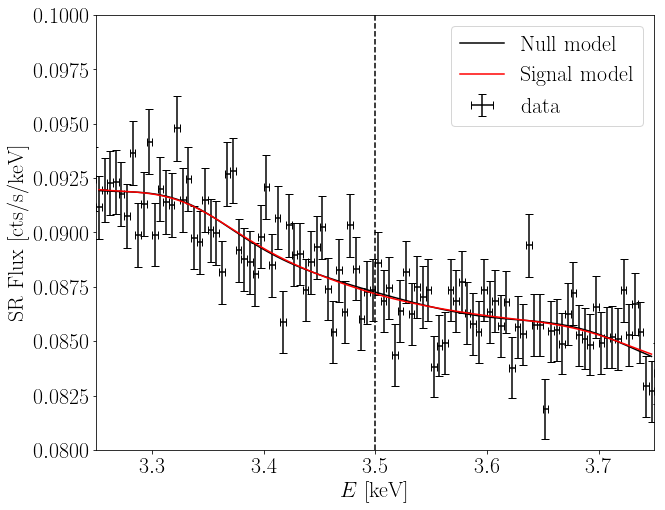

In [16]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_null_line.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_line.x[1:])+mn_line.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.08,0.1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Finally let's compute the associated limit via profile likelihood.

In [17]:
A_sig_array = np.linspace(mn_line.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn_line.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.01897045346926765 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.635695400354734e-11


Note that including the background lines has made the limit on $\sin^2(2\theta)$ in this case slightly weaker.  In general one finds a slight decrease in sensitivity due to the additional background parameters.  Note that this limit is consistent with that at $m_s = 7.1$ keV in Fig. S14 of Dessert et al. 2020, though again we stress that that plot was constructed from the joint likelihood. 

## Powerlaw background model

In [23]:
def mod_power_two_lines(ens,x):
    "An extended background model to include two additional lines"
    A, n, S1, S2 = x

    return A*ens**n +  S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_power_two_lines,mod_UXL_reduced)

mn_null_line = minimize(chi2_instance.chi2_null,np.array([0.18244131, -0.58714693,  0.02237754,  0.01157593]),method='Nelder-Mead')

mn_line = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null_line.x[0],mn_null_line.x[1],mn_null_line.x[2],mn_null_line.x[3]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})


print "The Delta chi^2 between signal and null model is:", mn_null_line.fun - mn_line.fun
print "The chi^2/DOF of the null-model fit is:", mn_null_line.fun/(len(whs_reduced)-4.)

The Delta chi^2 between signal and null model is: 0.15767885985397356
The chi^2/DOF of the null-model fit is: 0.9912920115487585


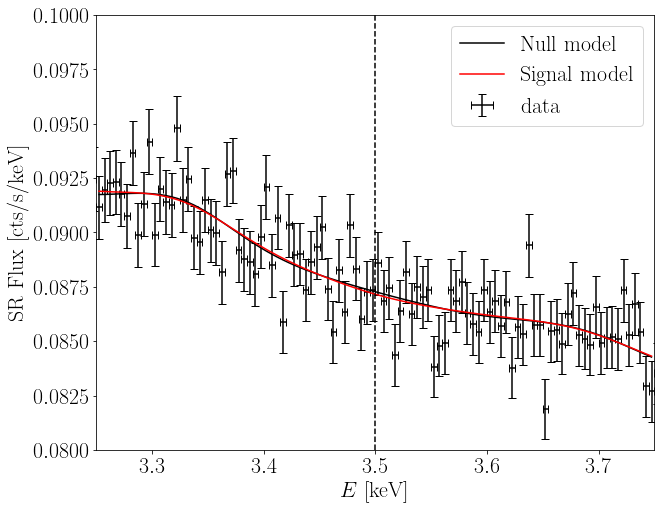

In [24]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_power_two_lines(Energies_reduced,mn_null_line.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_power_two_lines(Energies_reduced,mn_line.x[1:])+mn_line.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.08,0.1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [25]:
A_sig_array = np.linspace(mn_line.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn_line.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.017696689616776555 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.525867257446443e-11


# Is there something special about $[E_{\rm UXL}-0.25,\,E_{\rm UXL}+0.25]$ keV?

No.  We used a narrow energy range to mitigate possible systematic issues due to imperfections in the null model, but this doesn't mean that we find qualitatively different results if we were to use a wider energy range.  Let's explore the energy range from 3.0 to 4.0 keV.

As pointed out in e.g. [Boyarsky et al. 2018](https://arxiv.org/pdf/1812.10488.pdf), there is a large astrophysical line at ~3.1 keV and also at ~3.9 keV.  We will include both of these lines, in addition to the 3.3 and 3.7 keV lines included above.

Our procedure is as follows. Firstly, we update the dataset. Then we will define a new background model incorporating these additional lines. Finally we repeat our default $\chi^2$ fit procedure.

In [32]:
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

arg_3p1 = np.argmin((Es_line-3.12)**2) 
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p9]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]


def mod_power_four_lines(ens,x):
    A, n,S1, S2, S3, S4 = x
    return A*ens**n + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_power_four_lines,mod_UXL_reduced)


x0 = np.array([0.18088868 ,-0.58201284 , 0.02472505 , 0.01364361 , 0.08959867,
  0.03220519])
bounds = np.array([[1e-6,5],[-3,0],[0,0.5],[0,0.5],[0,0.5],[0,0.5]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

boundss = np.array([[-0.5,0.5],[1e-6,5],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-6.)

print "NB: the best-fit signal strength in this case is:", mn.x[0], " cts/cm$^2$/s/sr"





Best fit background parameters: [ 0.1807753  -0.58187775  0.02547398  0.01436228  0.09052193  0.03304785]
Best fit signal+background parameters: [-0.00153386  0.18091466 -0.58211865  0.02462782  0.01367684  0.08958076
  0.0321821 ]
The Delta chi^2 between signal and null model is: 0.03324299216930626
The chi^2/DOF of the null-model fit is: 0.9791145496670692
NB: the best-fit signal strength in this case is: -0.0015338613336035416  cts/cm$^2$/s/sr


In [33]:
flux_ill = 4.8e-11 / return_sin_theta_lim(EUXL,0.1,D_signal)*0.1
print "Flux [cts/cm^2/s/sr] and sin^(2\theta) for illustration: ", flux_ill, return_sin_theta_lim(EUXL,flux_ill,D_signal)

chi2_instance.fix_signal_strength(flux_ill)

mn_f = dual_annealing(chi2_instance.chi2_fixed_signal,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)
print mn_f.fun-mn_null.fun
print "\delta chi^2 between fixed signal and null:", mn_f.fun-mn_null.fun




Flux [cts/cm^2/s/sr] and sin^(2	heta) for illustration:  0.0556693970239 4.8e-11
46.377095279262704
\delta chi^2 between fixed signal and null: 46.377095279262704


In [34]:
def avg_data(data,n):
    return np.mean(data.reshape(-1, n), axis=1)


Let's have a look at the best fit signal and background models in this case. There are subtle difference between the two, but no clear excess is appearing at 3.55 keV.

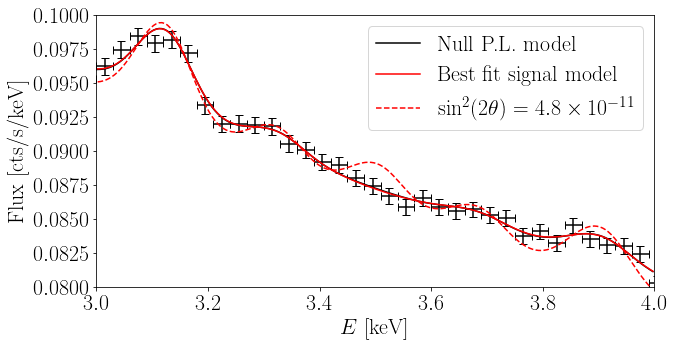

In [35]:
fig = plt.figure(figsize=(10,5))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) 

plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")
plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")
plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn_f.x)+chi2_instance._A_sig*mod_UXL_reduced,
         'r--',label =r"$\sin^2(2\theta) = 4.8 \times 10^{-11}$")

plt.xlim(3,4)
plt.ylim(0.08,0.1)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
#plt.savefig("response_fig.pdf",bbox_inches="tight")
plt.show()

Finally, we compute the limit in this case using the by now familiar procedure.

In [36]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.012520828121015607 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.0795873171590595e-11


## Now with a polynomial background

In [50]:
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

arg_3p1 = np.argmin((Es_line-3.12)**2) #3.12 #should really be 3.128
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p9]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]

def mod_poly_four_lines(ens,x):
    A, B, C,S1, S2, S3, S4 = x
    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_four_lines,mod_UXL_reduced)


x0 = np.array([ 0.2015824 , -0.05098609 , 0.0052141 ,  0.02854594 , 0.01742288,
  0.08976637 , 0.029351 ])
bounds = np.array([[-1,1],[-0.5,0.5],[-0.1,0.1],[0,0.2],[0,0.2],[0,0.2],[0,0.2]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=3000)

boundss = np.array([[-0.5,0.5],[-1,1],[-0.5,0.5],[-0.1,0.1],[0,0.2],[0,0.2],[0,0.2],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=3000)

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-7.)

print "NB: the best-fit signal strength in this case is:", mn.x[0], " cts/cm$^2$/s/sr"





Best fit background parameters: [ 0.20091551 -0.05052423  0.00514508  0.02652786  0.01548994  0.08761685
  0.02739853]
Best fit signal+background parameters: [ 0.00335325  0.20089327 -0.0505638   0.00515066  0.02826916  0.01729149
  0.08954285  0.02951016]
The Delta chi^2 between signal and null model is: 0.15936493120571527
The chi^2/DOF of the null-model fit is: 0.980518891711762
NB: the best-fit signal strength in this case is: 0.0033532451755897744  cts/cm$^2$/s/sr


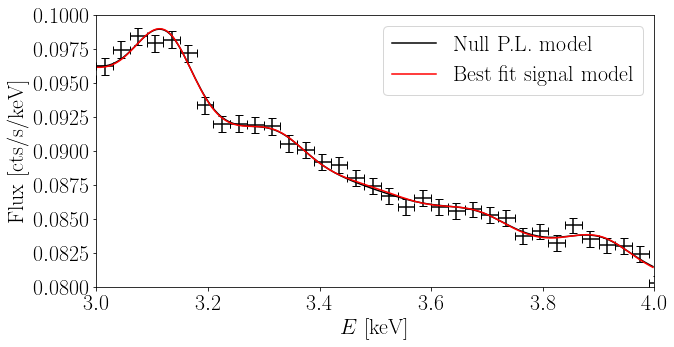

In [51]:
fig = plt.figure(figsize=(10,5))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) 

plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")

plt.xlim(3,4)
plt.ylim(0.08,0.1)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [52]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.023142777525339567 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.9954470150624295e-11


## Subtract background

Now, we subract off the data taken far away from the Galactic Center.  We use a folded powerlaw under the assumption that the residual flux in the signal region should be astrophysical.

In [56]:
def mod_folded_power_four_lines(ens,x):
    A, n,S1, S2, S3, S4 = x
    return folded_PL(A,n)[whs_reduced] + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]


chi2_instance = chi2(Energies_reduced,data_reduced- data_bkg[whs_reduced],np.sqrt(data_yerrs_reduced**2+data_yerrs_bkg_reduced**2),mod_folded_power_four_lines,mod_UXL_reduced)


x0 = np.array([2.64461842e-02, -5.26678226e-01,  1.18394708e-02,
  6.33227906e-04 , 6.87374544e-02 , 1.57555578e-024])
bounds = np.array([[0.0,0.1],[-2,0],[0,0.1],[0,0.2],[0,0.2],[0,0.2]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

boundss = np.array([[-0.5,0.5],[0.0,0.1],[-2,0],[0,0.1],[0,0.2],[0,0.2],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)


print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-6.)

print "NB: the best-fit signal strength in this case is:", mn.x[0], " cts/cm$^2$/s/sr"





Best fit background parameters: [ 2.62923228e-02 -5.21648841e-01  1.17720953e-02  3.09606610e-04
  6.87633354e-02  1.54837651e-02]
Best fit signal+background parameters: [-7.25569762e-06  2.62675599e-02 -5.20905065e-01  1.17812221e-02
  3.02204698e-04  6.87830918e-02  1.54688624e-02]
The Delta chi^2 between signal and null model is: 2.227822872669094e-05
The chi^2/DOF of the null-model fit is: 1.0151859326713606
NB: the best-fit signal strength in this case is: -7.255697620223273e-06  cts/cm$^2$/s/sr


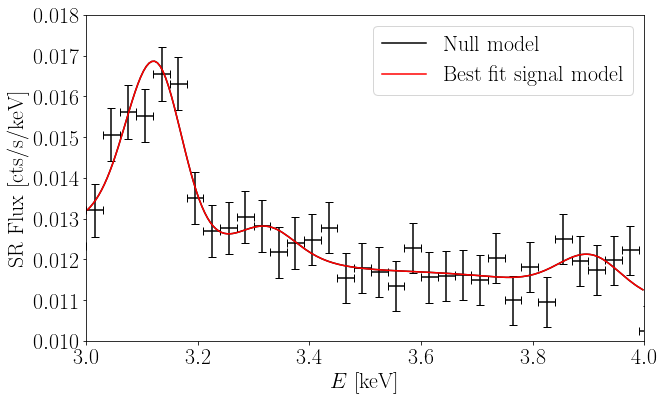

In [57]:
fig = plt.figure(figsize=(10,6))

plt.errorbar(avg_data(Energies,6),avg_data(data-data_bkg,6),yerr=np.sqrt(6*avg_data(data_yerrs**2+data_yerrs_bkg**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) #label="data"

plt.plot(Energies_reduced,mod_folded_power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_folded_power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")

plt.xlim(3,4)

plt.ylim(0.01,0.018)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [58]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal-D_bkg)

The 95% upper limit on the signal flux is 0.014136210560292569 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.6523296125292567e-11


Note that the 95\% upper limit in this case is stronger than it was in the smaller energy range! That is, the limit went from $\sin^2(2\theta) < 1.7 \times 10^{-11}$ to $\sin^2(2\theta) < 7.5 \times 10^{-12}$ when increasing the energy range.  This is _precisely_ what you would expect.  Going to a larger energy range better constrains the null model component, which in turn makes the limit and detection capabilities for the signal component stronger.  On the other hand, going to a larger energy range opens one up more to systematic uncertainties, since it is less clear that the null model can describe the data over the full energy range in this case.  This is why we use a narrower energy range and quote the weaker but more conservative limits.

# Now do QPB

Now we will do a joint likelihood including the QPB data.  The QPB data is complicated because the data is correlated from observation to observation.  Thus, summing the data leads to correlated uncertainties.  Thus, we will estimate the uncertainties on the QPB data in a data-driven way by fixing the normalization of the $\chi^2$ function such that the powerlaw gives the expected $\chi^2/{\rm DOF}$.  We note that this is just an approximation, which is not necessary within the context of the full joint likelihood framework.


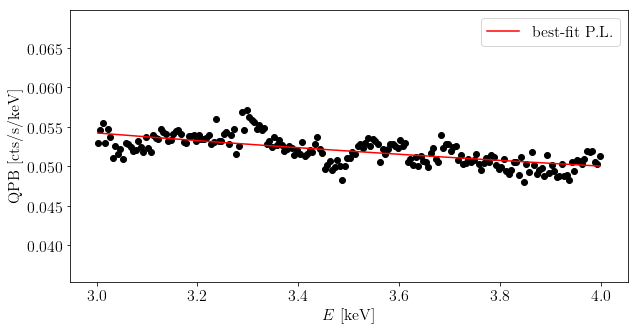

In [59]:
# We are going to fix a powerlaw to the QPB data and then renormalize the chi^2 function
def PL(A,n,ens):
    return A*ens**n
def chi2_QPB_UN(x):
    A,n = x
    mod = PL(A,n,Energies_reduced)
    return np.sum((mod-QPB[whs_reduced])**2)

mn_QPB = minimize(chi2_QPB_UN,[0.084,-0.20],method="Nelder-Mead")
bf_QPB=mn_QPB.x

chi2_not_reduced = chi2_QPB_UN(bf_QPB)
# The function below has the expected normalization
chi2_QPB = lambda x: chi2_QPB_UN(x)/chi2_not_reduced*((len(QPB[whs_reduced])-2.))


fig = plt.figure(figsize=(10,5))
plt.scatter(Energies_reduced,QPB[whs_reduced],marker="o",color="black")
plt.plot(Energies_reduced,PL(bf_QPB[0],bf_QPB[1],Energies_reduced),'r-',label="best-fit P.L.")
plt.xlabel(r"$E$ [keV]",fontsize=16)
plt.ylabel(r"QPB [cts/s/keV]",fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [63]:
def mod_2power_four_lines(ens,x):
    AQPB, nQPB,A, n,S1, S2, S3, S4 = x
    return PL(AQPB,nQPB,ens)+ folded_PL(A,n)[whs_reduced] + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_2power_four_lines,mod_UXL_reduced)


x0 = np.array([0.07377512 ,-0.28001362 , 0.15844243, -1.07912658 , 0.02877547,
  0.01134023 , 0.08755627 , 0.03134949])
bounds = np.array([[0.75*bf_QPB[0],1.25*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.1]])

# Below is the joint likelihood for the null model
def joint_chi2(x):
    return chi2_QPB(x[:2])+chi2_instance.chi2_null(x)

mn_null = dual_annealing(joint_chi2,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

# Below is the joint likelihood for the signal model
def joint_chi2_sig(x):
    return chi2_QPB(x[1:3])+chi2_instance.chi2(x)
boundss = np.array([[-0.5,0.5],[0.5*bf_QPB[0],2*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.1]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6],mn_null.x[7]])
mn = dual_annealing(joint_chi2_sig,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)



In [64]:
print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun

print "NB: the best-fit signal strength in this case is:", mn.x[0], " cts/cm$^2$/s/sr"



Best fit background parameters: [ 0.07369189 -0.27910375  0.15831373 -1.07680396  0.02739624  0.00976562
  0.08610641  0.02945654]
Best fit signal+background parameters: [ 0.00285063  0.07359496 -0.27804545  0.16021193 -1.08816103  0.02870365
  0.0117113   0.08713338  0.03195219]
The Delta chi^2 between signal and null model is: 0.08774952146296755
NB: the best-fit signal strength in this case is: 0.0028506317170190745  cts/cm$^2$/s/sr


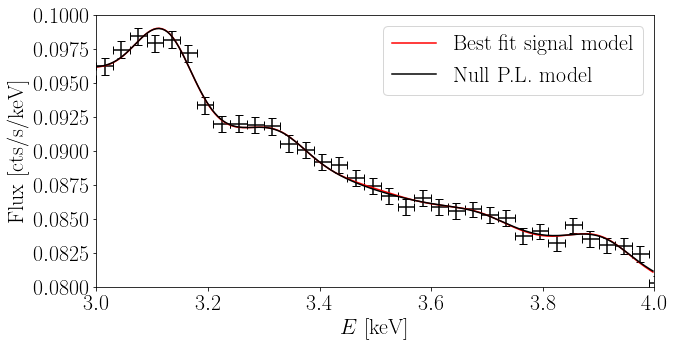

In [65]:
fig = plt.figure(figsize=(10,5))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) #label="data"


plt.plot(Energies_reduced,mod_2power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")
x0 = np.array([bf_QPB[0],bf_QPB[1], 0.064218, -0.4306988 , 0.02542355 , 0.01451921 , 0.09027154,  0.03331636])
plt.plot(Energies_reduced,mod_2power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")



plt.xlim(3,4)

plt.ylim(0.08,0.1)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [66]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.016662062830215506 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.4366583052933853e-11
